## Performance evaluation of the trained model ##
Demonstates how to evaluate the trained model from a checkpoint

In [1]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import glob

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score 
from sklearn.metrics import accuracy_score

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch import Trainer
import torchmetrics

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Appearance of plots
plt.style.use('ggplot')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import computervision as dm
from computervision.imageproc import ImageData
from computervision.fileutils import FileOP
from computervision.torchdataset import DatasetFromDF, load_and_process_image

print(f'dentexmodel package version:  {dm.__version__}')

dentexmodel package version:  0.0.post1.dev48+g56bd7cc.d20240808


In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

# Lets run inference on the CPU
device = torch.device("cpu")
torch.set_float32_matmul_precision(precision='high')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce RTX 3070 Laptop GPU
CUDNN version:         90201

Device for model training/inference: cuda:0


In [3]:
# Path settings 
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = os.environ.get('DATA_ROOT')

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
cropped_image_dir = os.path.join(image_dir, 'crop')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(data_dir, data_file_name)

### Load the test data ###

In [4]:
data_df = pd.read_parquet(data_file)
display(data_df.head(2))

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
0,272,train_191.png,191,/app/data/dentex/dentex_classification/quadran...,1,8,Impacted,0,39275,"[677.0, 446.0, 276.0, 207.0]",train_191_1435_1_8,9,/app/data/dentex/dentex_classification/quadran...,276,207,train
1,600,train_418.png,418,/app/data/dentex/dentex_classification/quadran...,1,7,Caries,1,34312,"[790.2912621359224, 372.81553398058253, 141.74...",train_418_3035_1_7,9,/app/data/dentex/dentex_classification/quadran...,142,310,train


In [5]:
# Create the class dictionary from the data frame
label_col = 'cl'
label_list = sorted(list(data_df['label'].unique()))
label_cl = [data_df.loc[data_df['label'] == label, label_col].values[0] for label in label_list]
label_dict = dict(zip(label_cl, label_list))
display(label_dict)

test_df = data_df.loc[data_df['dataset'] == 'test']

test_samples = sorted(list(test_df['box_name'].unique()))
print(f'Found {len(test_samples)} samples in the test set.')
print()
display(test_df['label'].value_counts())
print()
display(test_df.head())

{1: 'Caries', 3: 'Deep Caries', 0: 'Impacted', 2: 'Periapical Lesion'}

Found 120 samples in the test set.



label
Deep Caries          30
Impacted             30
Periapical Lesion    30
Caries               30
Name: count, dtype: int64

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
47,360,train_248.png,248,/app/data/dentex/dentex_classification/quadran...,3,6,Deep Caries,3,15680,"[1763.0, 617.0, 125.0, 170.0]",train_248_1898_3_6,4,/app/data/dentex/dentex_classification/quadran...,125,170,test
83,17,train_564.png,564,/app/data/dentex/dentex_classification/quadran...,1,8,Impacted,0,8873,"[448.25, 282.0, 101.25, 128.75]",train_564_107_1_8,10,/app/data/dentex/dentex_classification/quadran...,102,129,test
196,520,train_420.png,420,/app/data/dentex/dentex_classification/quadran...,4,8,Deep Caries,3,26130,"[659.1836734693877, 746.7755102040816, 206.122...",train_420_2692_4_8,11,/app/data/dentex/dentex_classification/quadran...,206,196,test
233,633,train_53.png,53,/app/data/dentex/dentex_classification/quadran...,2,8,Impacted,0,22225,"[2210.0, 418.0, 176.0, 181.0]",train_53_3163_2_8,10,/app/data/dentex/dentex_classification/quadran...,176,181,test
256,370,train_631.png,631,/app/data/dentex/dentex_classification/quadran...,4,8,Impacted,0,33393,"[686.5853658536585, 763.4146341463414, 175.609...",train_631_1951_4_8,2,/app/data/dentex/dentex_classification/quadran...,175,281,test


In [6]:
# Create a pytorch data set from the data frame
# Vor validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
# The output of this transformation must match the required input size for the model
max_image_size = 550
im_size = 224
batch_size = 6

# We need the same normalization as we used for training
val_transform = alb.Compose([alb.Resize(im_size, im_size),
                             alb.Normalize(mean=ImageData().image_net_mean, 
                                           std=ImageData().image_net_std)])

# Create the PyTorch dataset
test_dataset = DatasetFromDF(data=test_df,
                             file_col='box_file',
                             label_col=label_col,
                             max_image_size=max_image_size,
                             transform=val_transform,
                             validate=True)
# Create a data loader
dl = DataLoader(test_dataset,
                batch_size=batch_size,
                num_workers=0,
                shuffle=False)

INFO:computervision.imageproc:All files validated.


### Load the model from a checkpoint ###

In [8]:
from computervision.models.toothmodel_fancy import ToothModel
link = 'https://dsets.s3.amazonaws.com/dentex/toothmodel_fancy_40.ckpt'

# Let's see if we have a saved checkpoint
# The previous training notebook should have the defined model name
model_name = 'FancyLR'
model_version = 1

# The latest checkpoint should be here
checkpoint_dir = os.path.join(model_dir, 
                              model_name,
                              f'version_{model_version}',
                              'checkpoints')

last_checkpoint = glob.glob(os.path.join(checkpoint_dir, 'last.ckpt'))
if len(last_checkpoint) > 0:
    print(f'Using checkpoint file "last.ckpt" in {checkpoint_dir}.')
    checkpoint_file = last_checkpoint[0]
else:
    print(f'Last checkpoint file "last.ckpt" not found in {checkpoint_dir}.')
    print(f'Downloading checkpoint from {link}')
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_file = FileOP().download_from_url(url=link, download_dir=checkpoint_dir)

Using checkpoint file "last.ckpt" in /app/data/model/FancyLR/version_1/checkpoints.


### Instantiate the model with weights from checkpoint file ###

In [9]:
batch_size = 16
num_classes = 4
model = ToothModel.load_from_checkpoint(checkpoint_file,
                                        test_dataset=test_dataset, 
                                        map_location=device,
                                        batch_size=batch_size,
                                        num_classes=num_classes,
                                        num_workers=1)
sm = nn.Softmax(dim=1)

### Predict on the test set ###
This could be done better with a test_step method. But this works too.

In [10]:
pred_df_batch_list = []
for image_batch, label_batch in dl:
    pred_df_batch = pd.DataFrame(sm(model(image_batch)).detach().numpy()).\
                    assign(cl=list(label_batch.detach().numpy()))
    pred_df_batch_list.append(pred_df_batch)
pred_df = pd.concat(pred_df_batch_list, axis=0, ignore_index=True)
display(pred_df.head())
print()
display(label_dict)

,0,1,2,3,cl
0,0.021142,0.707109,0.052924,0.218826,3
1,0.667701,0.241355,0.004405,0.086539,0
2,0.178267,0.621454,0.018012,0.182267,3
3,0.650790,0.246495,0.007995,0.094720,0
4,0.042620,0.679103,0.042573,0.235704,0


{1: 'Caries', 3: 'Deep Caries', 0: 'Impacted', 2: 'Periapical Lesion'}

### Evaluate model performance as binary classification tasks ###

Performance for class 1: "Caries"
{'precision': 0.3803, 'recall': 0.9, 'threshold': 0.6812999844551086, 'f1': 0.5347}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


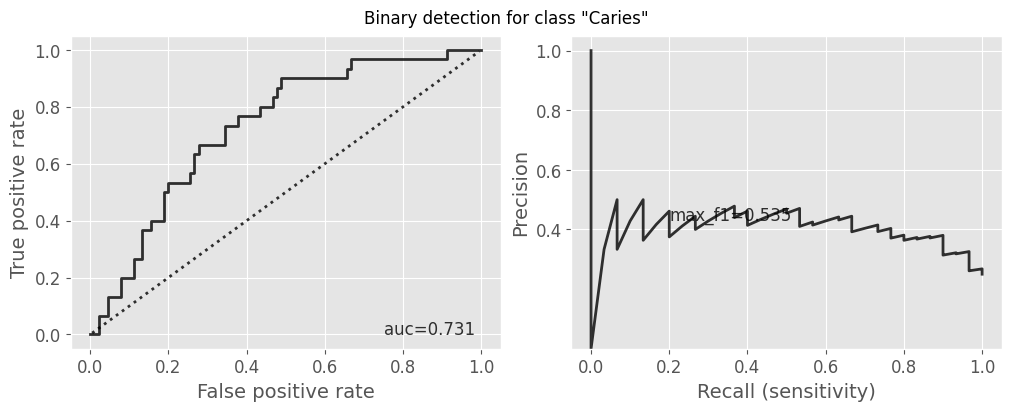


Performance for class 3: "Deep Caries"
{'precision': 0.2778, 'recall': 0.8333, 'threshold': 0.14059999585151672, 'f1': 0.4167}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


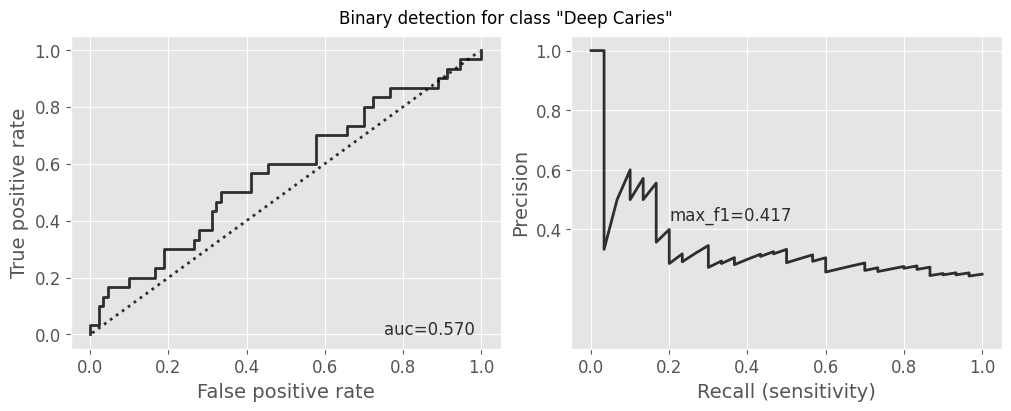


Performance for class 0: "Impacted"
{'precision': 0.8571, 'recall': 0.8, 'threshold': 0.2619999945163727, 'f1': 0.8276}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


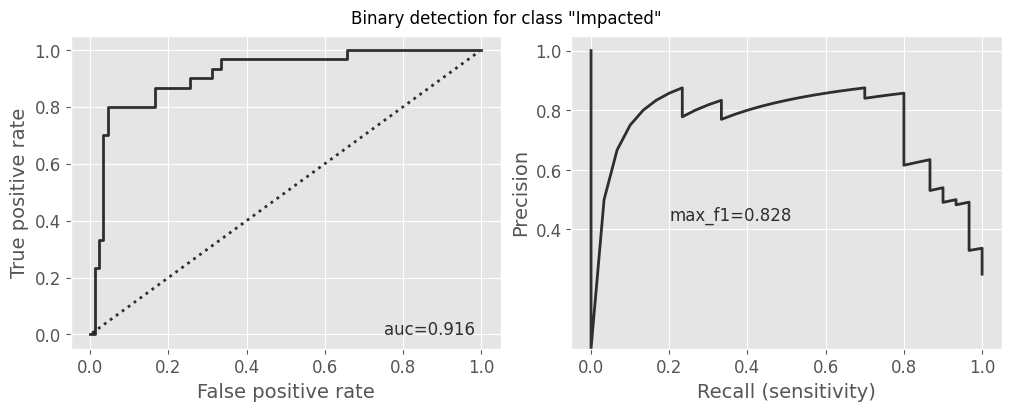


Performance for class 2: "Periapical Lesion"
{'precision': 0.4677, 'recall': 0.9667, 'threshold': 0.02280000038444996, 'f1': 0.6304}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


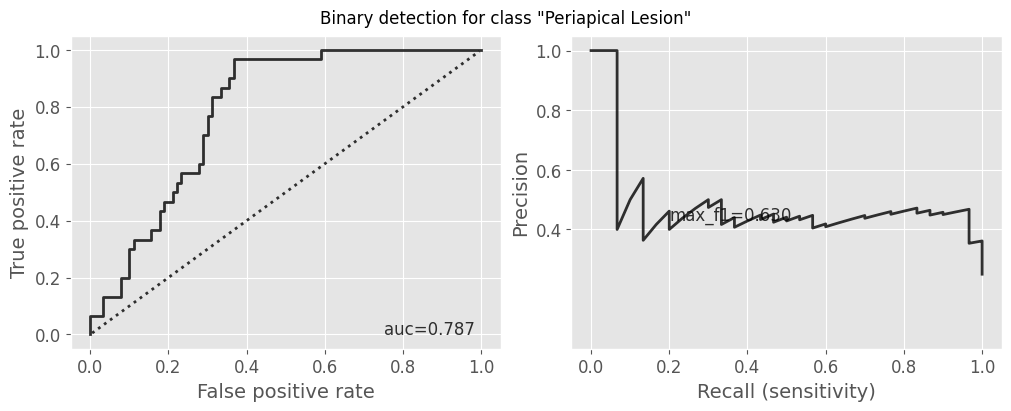

In [13]:
def max_f1_threshold(precision, recall, thr):
    """ Determine the threshold for the maximum f1 score """
    pdf = pd.DataFrame({'precision': np.round(precision, 4),
                        'recall': np.round(recall, 4),
                        'threshold': np.round(thr, 4)})
    pdf = pdf.assign(f1=np.round(2 * (pdf['precision'] * pdf['recall']) / (pdf['precision'] + pdf['recall']), 4))
    max_f1_dict = dict(pdf.loc[pdf['f1'] == pdf['f1'].max()].iloc[0])
    return max_f1_dict
    
def performance_plots(y_true, y_score, cl_name, figsize=(10,5)):
    # Metrics for ROC and P-R curves
    auc = roc_auc_score(y_true=y_true, y_score=y_score)
    fpr, tpr, r_thresholds = roc_curve(y_true=y_true, y_score=y_score)
    precision, recall, p_thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    max_f1_dict = max_f1_threshold(precision=precision[:-1], recall=recall[:-1], thr=p_thresholds)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, constrained_layout=True)
    # ROC curve
    ax[0].plot(fpr, tpr, color='k', linewidth=2.0, alpha=0.8)
    ax[0].text(x=0.75, y=0, s=f'auc={auc:.3f}', alpha=0.8)
    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
              xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0, 1.2, 0.2),
              xlabel='False positive rate', ylabel='True positive rate')
    ax[0].plot([0.05, 0.95], [0.05, 0.95], transform=ax[0].transAxes, color='k', 
               linewidth=2, alpha=0.8, linestyle=':')

    # PR curve
    ax[1].plot(recall, precision, color='k', linewidth=2.0, alpha=0.8)
    ax[1].text(x=0.2, y=0.43, s=f'max_f1={max_f1_dict.get("f1"):.3f}', alpha=0.8)
    ax[1].set(xlim=[-0.05, 1.05], ylim=[0.0, 1.05],
              xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.4, 1.2, 0.2),
              xlabel='Recall (sensitivity)', ylabel='Precision')

    fig.suptitle(f'Binary detection for class "{cl_name}"', fontsize=12)
    
    return fig, ax

figsize = (10, 4)
for cl, cl_name in list(label_dict.items()):
    y_true = [1 if c == cl else 0 for c in pred_df['cl'].values]
    y_score=pred_df[cl]
    print(f'Performance for class {cl}: "{cl_name}"')
    precision, recall, p_thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    max_f1_dict = max_f1_threshold(precision=precision[:-1], recall=recall[:-1], thr=p_thresholds)
    print(max_f1_dict)
    fig, ax = performance_plots(y_true=y_true, y_score=y_score, cl_name=cl_name, figsize=figsize)
    plt.show()
    print()